Train on 14666 samples, validate on 3667 samples
Epoch 1/60
14666/14666 [==============================] - 1s 55us/step - loss: 0.9702 - accuracy: 0.5910 - val_loss: 0.6746 - val_accuracy: 0.7404
Epoch 2/60
14666/14666 [==============================] - 1s 43us/step - loss: 0.6115 - accuracy: 0.7601 - val_loss: 0.4844 - val_accuracy: 0.8203
Epoch 3/60
14666/14666 [==============================] - 1s 42us/step - loss: 0.4688 - accuracy: 0.8247 - val_loss: 0.3791 - val_accuracy: 0.8677
Epoch 4/60
14666/14666 [==============================] - 1s 43us/step - loss: 0.3829 - accuracy: 0.8561 - val_loss: 0.3192 - val_accuracy: 0.8931
Epoch 5/60
14666/14666 [==============================] - 1s 42us/step - loss: 0.3254 - accuracy: 0.8797 - val_loss: 0.2655 - val_accuracy: 0.9054
Epoch 6/60
14666/14666 [==============================] - 1s 43us/step - loss: 0.2967 - accuracy: 0.8919 - val_loss: 0.2443 - val_accuracy: 0.9168
Epoch 7/60
14666/14666 [==============================] - 1s 43us/ste

14666/14666 [==============================] - 1s 42us/step - loss: 0.0870 - accuracy: 0.9750 - val_loss: 0.0928 - val_accuracy: 0.9782
Epoch 57/60
14666/14666 [==============================] - 1s 42us/step - loss: 0.1079 - accuracy: 0.9717 - val_loss: 0.1088 - val_accuracy: 0.9716
Epoch 58/60
14666/14666 [==============================] - 1s 41us/step - loss: 0.1017 - accuracy: 0.9734 - val_loss: 0.1144 - val_accuracy: 0.9708
Epoch 59/60
14666/14666 [==============================] - 1s 42us/step - loss: 0.0973 - accuracy: 0.9735 - val_loss: 0.1058 - val_accuracy: 0.9700
Epoch 60/60
14666/14666 [==============================] - 1s 42us/step - loss: 0.0939 - accuracy: 0.9754 - val_loss: 0.1102 - val_accuracy: 0.9705
Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 256)               33792     
____________________________________________________

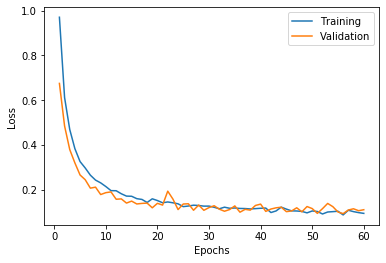

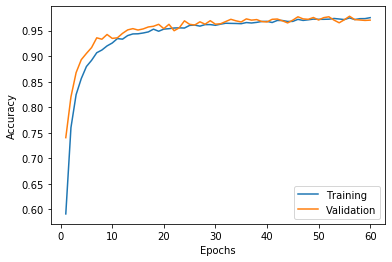

2037/2037 [==============================] - 0s 66us/step
Accuracy:  0.9705449189985272
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       485
           1       0.97      0.95      0.96       489
           2       0.98      0.98      0.98       507
           3       0.94      0.99      0.96       556

    accuracy                           0.97      2037
   macro avg       0.97      0.97      0.97      2037
weighted avg       0.97      0.97      0.97      2037



In [22]:
import math
import numpy as np
import csv as csv
from functools import partial
from collections import defaultdict
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from keras.utils import np_utils
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Dense, Activation, Dropout

def shuffle_dataset(xs, ys):
    idx = np.random.permutation(xs.shape[0])
    xs_result, ys_result = xs[idx], ys[idx]
    return xs_result, ys_result

def preprocess_data(x, scaler=None):
    if not scaler:
        scaler = StandardScaler()
        scaler.fit(x)
    x = scaler.transform(x)
    return x, scaler

def preprocess_labels(labels, encoder=None, categorical=True):
    if not encoder:
        encoder = LabelEncoder()
        encoder.fit(labels)
    y = encoder.transform(labels)
    if categorical:
        y = np_utils.to_categorical(y, num_classes=4)
    return y, encoder

def prepare_data(inp_path, split_size=0.25, shuffle=False, oversize=True, target_ratio=0.8):
    x = list()
    with open(inp_path) as f:
        x_reader = csv.reader(f, delimiter=";")
        for row in x_reader:
            x.append(row)
    x = np.array(x)

    y_index = np.where(x[0,:] == "Target")[0][0]
    y = x[1:,y_index].astype(np.float32)-1 #-1 is used to scale the target column to 0-base
    x = np.delete(x, y_index, axis=1)[1:,:].astype(np.float32)

    x, _ = preprocess_data(x)

    if(oversize):
        y = y.astype(np.int32)
        count_occ = defaultdict(int)
        for i in y:
            count_occ[i] += 1
        max_occ=(0,0)
        for i in count_occ.items():
            if(i[1]>max_occ[1]):
                max_occ = i
        sampling_dict = dict()
        for i in count_occ.items():
            if(i[0]!=max_occ[0] and i[1]<round(max_occ[1]*target_ratio)):
                sampling_dict[i[0]]=round(max_occ[1]*target_ratio)
            else:
                sampling_dict[i[0]]=max_occ[1]
        sm = SMOTE(random_state = 0, sampling_strategy = sampling_dict)
        x, y = sm.fit_sample(x, y)
        y = y.astype(np.float32)
    
    if (shuffle):
       x, y = shuffle_dataset(x, y)
    
    if split_size == 1:
        x_train = x
        x_test = None
        y_train = y
        y_test = None
    else: 
        r_size = x.shape[0]
        border = math.floor(r_size*(1-split_size))
        x_train = x[:border,:]
        x_test = x[border:,:]
        y_train = y[:border]
        y_test = y[border:]

    y_train, encoder = preprocess_labels(y_train)

    return x_train, y_train, x_test, y_test, encoder

def train(x_train, y_train, x_test, y_test, n_epochs=60, verbose=1):

    dims = x_train.shape[1]
    nb_classes = y_train.shape[1]

    model = Sequential()
    model.add(Dense(256, input_shape=(dims,), activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(160, activation = "relu"))
    model.add(Dropout(0.2))
    model.add(Dense(216, activation = "relu"))
    model.add(Dense(nb_classes, activation = "softmax"))

    model.compile(optimizer=Adam(learning_rate=0.002090922710075333, beta_1=0.9199471584216276, beta_2=0.9788631577850126),
        loss='categorical_crossentropy', metrics=['accuracy'])


    network_history = model.fit(x_train, y_train, batch_size=32, epochs=n_epochs, verbose=verbose, validation_split=0.2)
    return model, network_history

def evaluate_acc(x_train, y_train, x_test, y_test, encoder=None):
    model, _ = train(x_train, y_train, x_test, y_test, verbose=0)
    labels=model.predict_classes(x_test, batch_size=32, verbose=0)
    labels, _ = preprocess_labels(labels, encoder=encoder)
    return accuracy_score(labels, y_test)

def score(inp_path):

    x_train, y_train, x_test, y_test, _ = prepare_data(inp_path, split_size=0.1, shuffle=True, oversize=True, target_ratio=0.8)
    model, network_history = train(x_train, y_train, x_test, y_test)
    import matplotlib.pyplot as plt
    %matplotlib inline
    
    model.summary()
    x_plot = list(range(1,61))

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.plot(x_plot, network_history.history['loss'])
    plt.plot(x_plot, network_history.history['val_loss'])
    plt.legend(['Training', 'Validation'])

    plt.figure()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.plot(x_plot, network_history.history['accuracy'])
    plt.plot(x_plot, network_history.history['val_accuracy'])
    plt.legend(['Training', 'Validation'], loc='lower right')
    plt.show()

    labels=model.predict_classes(x_test, batch_size=32, verbose=1)
    print("Accuracy: ", accuracy_score(labels, y_test))
    print(classification_report(labels, y_test))

score('train.csv')

In [21]:
model.summary()

NameError: name 'model' is not defined